In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
%matplotlib inline
from jax.nn import sigmoid, log_sigmoid

In [2]:
N = 1000
K = 10

np.random.seed(2)

X = np.random.randn(N, K)
beta_true = np.random.randn(K)
gamma_true = np.random.normal()

logit_true = X @ beta_true + gamma_true

y = np.random.uniform(size=N) < sigmoid(logit_true)

In [3]:
import pystan
from stan_utils import load_stan_model_cached

# Fit this with Stan

model_data = {
    'X': X,
    'y': y.astype(int),
    'N': N,
    'K': K
}

stan_model = load_stan_model_cached('./stan_log_reg.stan')

/home/martin/miniconda3/envs/jax/lib/python3.7/site-packages/jax/lax/lax.py:6188: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [4]:
fit_result = stan_model.sampling(data=model_data)

In [5]:
print(fit_result)

Inference for Stan model: anon_model_13e2503bce983084faaf24120f53644d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]   -0.83  1.4e-3    0.1  -1.04   -0.9  -0.83  -0.76  -0.65   5602    1.0
beta[2]   -0.45  1.1e-3    0.1  -0.65  -0.52  -0.45  -0.38  -0.25   7927    1.0
beta[3]   -0.34  1.1e-3   0.09  -0.52   -0.4  -0.34  -0.28  -0.16   6904    1.0
beta[4]   -0.34  1.0e-3   0.09  -0.52   -0.4  -0.34  -0.28  -0.16   7702    1.0
beta[5]   -1.72  1.9e-3   0.13  -1.98  -1.81  -1.72  -1.64  -1.48   4492    1.0
beta[6]    0.57  1.2e-3    0.1   0.37    0.5   0.57   0.63   0.76   7322    1.0
beta[7]   -0.81  1.3e-3    0.1  -1.01  -0.88  -0.81  -0.74  -0.62   6334    1.0
beta[8]    0.15  1.1e-3   0.09  -0.03   0.09   0.15   0.21   0.33   6825    1.0
beta[9]   -1.42  1.8e-3   0.12  -1.66   -1.5  -1.42  -1.34  -1.18   4620    1.0
beta[10]  -

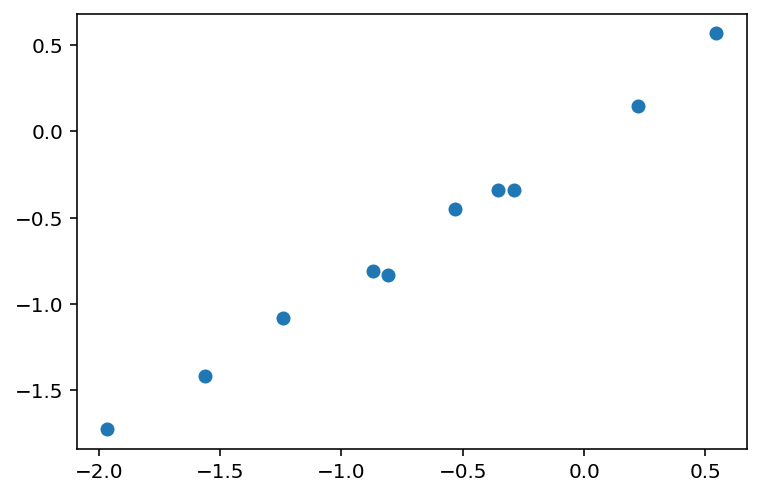

In [6]:
plt.scatter(beta_true, fit_result['beta'].mean(axis=0))

In [7]:
gamma_true

0.25193706697790286

In [8]:
from jax_advi.advi import optimize_advi_mean_field
from jax import jit
from jax.scipy.stats import norm

In [9]:
# Try ADVI
theta_shapes = {
    'beta': (K),
    'gamma': ()
}

In [10]:
def calculate_likelihood(theta, X, y):
    
    logit_prob = X @ theta['beta'] + theta['gamma']
    
    prob_pres = log_sigmoid(logit_prob)
    prob_abs = log_sigmoid(-logit_prob)
    
    return jnp.sum(y * prob_pres + (1 - y) * prob_abs)

def calculate_prior(theta):
    
    beta_prior = jnp.sum(norm.logpdf(theta['beta']))
    gamma_prior = jnp.sum(norm.logpdf(theta['gamma']))
    
    return beta_prior + gamma_prior

In [11]:
from functools import partial

In [12]:
log_lik_fun = jit(partial(calculate_likelihood, X=X, y=y))
log_prior_fun = jit(calculate_prior)

In [13]:
result = optimize_advi_mean_field(theta_shapes, log_prior_fun, log_lik_fun, n_draws=None)

In [14]:
# Get the ADVI draws
from jax_advi.advi import get_posterior_draws

draws = get_posterior_draws(result['free_means'], result['free_sds'], {}, n_draws=10000)

beta_means_advi = draws['beta'].mean(axis=0)
beta_sds_advi = draws['beta'].std(axis=0)

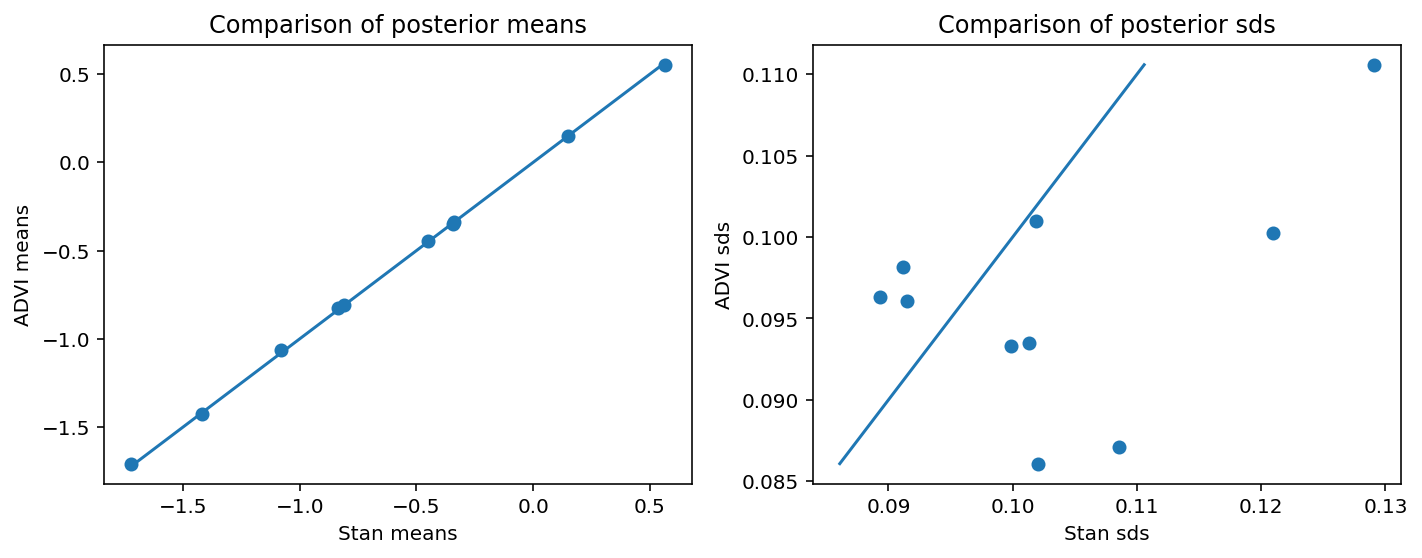

In [15]:
f, ax = plt.subplots(1, 2)

ax[0].scatter(fit_result['beta'].mean(axis=0), beta_means_advi)

ax[0].plot([beta_means_advi.min(), beta_means_advi.max()],
           [beta_means_advi.min(), beta_means_advi.max()])

ax[1].scatter(fit_result['beta'].std(axis=0), beta_sds_advi)
ax[1].plot([beta_sds_advi.min(), beta_sds_advi.max()],
              [beta_sds_advi.min(), beta_sds_advi.max()])

ax[0].set_title('Comparison of posterior means')
ax[1].set_title('Comparison of posterior sds')

ax[0].set_xlabel('Stan means')
ax[0].set_ylabel('ADVI means')

ax[1].set_xlabel('Stan sds')
ax[1].set_ylabel('ADVI sds')

f.set_size_inches(10, 4)
f.tight_layout()

plt.savefig('logistic_reg_comparison.png', dpi=300)

In [16]:
# Try LRVB
from jax_advi.lrvb import compute_lrvb_covariance, get_posterior_draws_lrvb

In [17]:
lrvb_free_sds, lrvb_cov_mat = compute_lrvb_covariance(
    result['final_var_params_flat'], result['objective_fun'], result['shape_summary'],
    batch_size=11)

  0%|          | 0/1 [00:00<?, ?it/s]/home/martin/miniconda3/envs/jax/lib/python3.7/site-packages/jax/lax/lax.py:6188: UserWarning: Explicitly requested dtype <class 'float'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


In [18]:
# Make draws from the LRVB objective
lrvb_draws = get_posterior_draws_lrvb(np.split(result['final_var_params_flat'], 2)[0],
                                     lrvb_cov_mat, result['shape_summary'], {}, n_draws=10000)

beta_means_lrvb = lrvb_draws['beta'].mean(axis=0)
beta_sds_lrvb = lrvb_draws['beta'].std(axis=0)

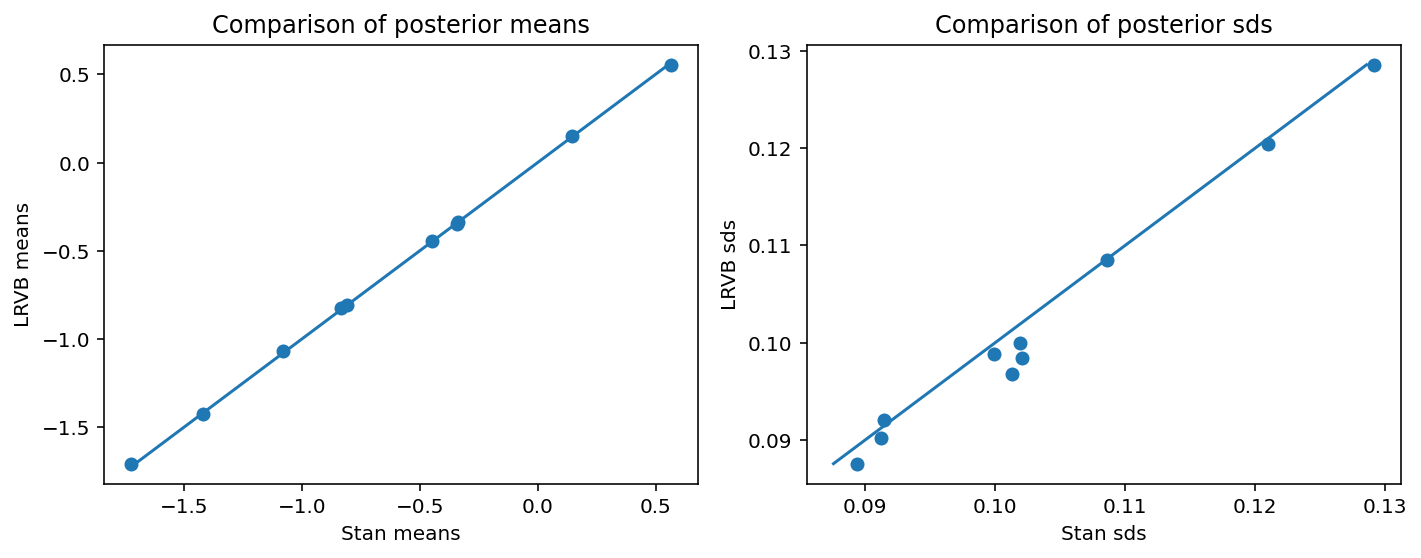

In [19]:
# Compare with HMC
f, ax = plt.subplots(1, 2)

ax[0].scatter(fit_result['beta'].mean(axis=0), beta_means_lrvb)

ax[0].plot([beta_means_lrvb.min(), beta_means_lrvb.max()],
           [beta_means_lrvb.min(), beta_means_lrvb.max()])

ax[1].scatter(fit_result['beta'].std(axis=0), beta_sds_lrvb)
ax[1].plot([beta_sds_lrvb.min(), beta_sds_lrvb.max()],
              [beta_sds_lrvb.min(), beta_sds_lrvb.max()])

ax[0].set_title('Comparison of posterior means')
ax[1].set_title('Comparison of posterior sds')

ax[0].set_xlabel('Stan means')
ax[0].set_ylabel('LRVB means')

ax[1].set_xlabel('Stan sds')
ax[1].set_ylabel('LRVB sds')

f.set_size_inches(10, 4)
f.tight_layout()

plt.savefig('logistic_reg_comparison_lrvb.png', dpi=300)

In [20]:
beta_draws_lrvb = lrvb_draws['beta']

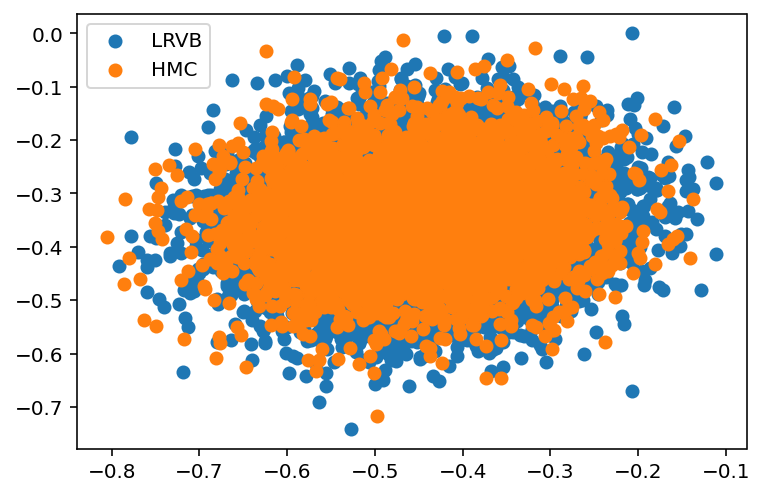

In [21]:
plt.scatter(beta_draws_lrvb[:, 1], beta_draws_lrvb[:, 3], label='LRVB')
plt.scatter(fit_result['beta'][:, 1], fit_result['beta'][:, 3], label='HMC')
plt.legend()

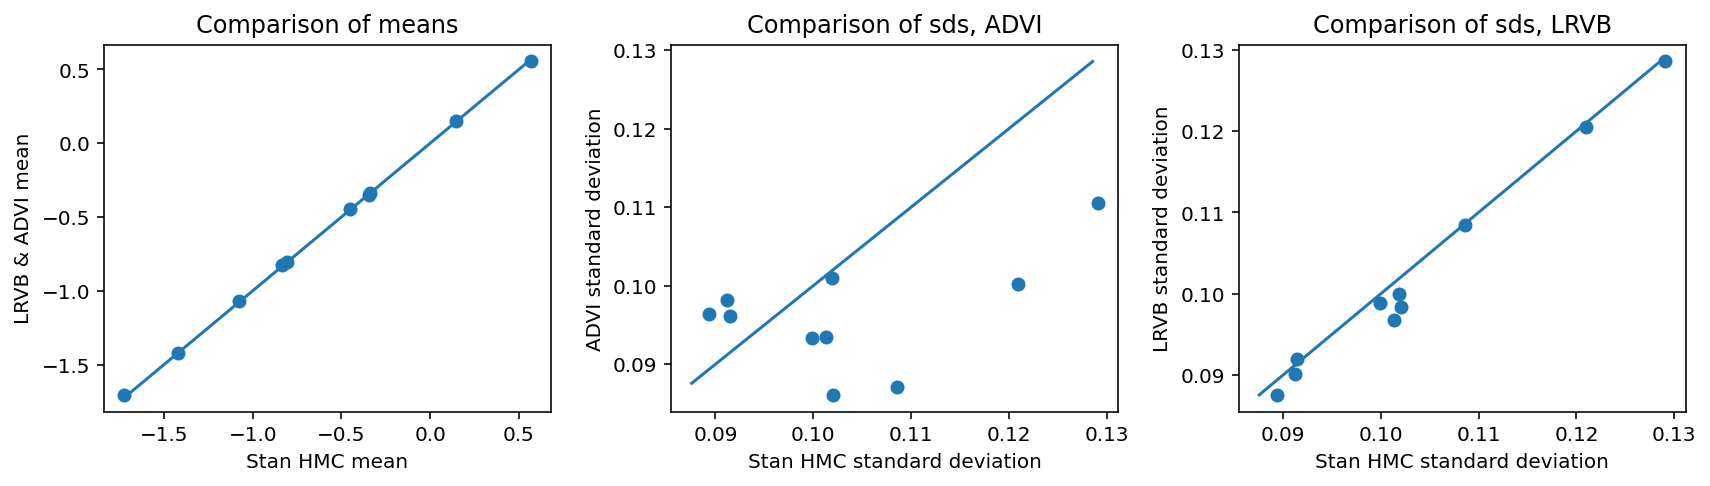

In [37]:
# All three approaches together:
f, ax = plt.subplots(1, 3)

ax[0].scatter(fit_result['beta'].mean(axis=0), beta_means_lrvb)

ax[0].plot([beta_means_lrvb.min(), beta_means_lrvb.max()],
           [beta_means_lrvb.min(), beta_means_lrvb.max()])

ax[1].scatter(fit_result['beta'].std(axis=0), beta_sds_advi)
ax[1].plot([beta_sds_lrvb.min(), beta_sds_lrvb.max()],
              [beta_sds_lrvb.min(), beta_sds_lrvb.max()])

ax[2].scatter(fit_result['beta'].std(axis=0), beta_sds_lrvb)
ax[2].plot([beta_sds_lrvb.min(), beta_sds_lrvb.max()],
              [beta_sds_lrvb.min(), beta_sds_lrvb.max()])

ax[0].set_title('Comparison of means')
ax[1].set_title('Comparison of sds, ADVI')
ax[2].set_title('Comparison of sds, LRVB')

ax[0].set_xlabel('Stan HMC mean')
ax[0].set_ylabel('LRVB & ADVI mean')

ax[1].set_xlabel('Stan HMC standard deviation')
ax[1].set_ylabel('ADVI standard deviation')

ax[2].set_xlabel('Stan HMC standard deviation')
ax[2].set_ylabel('LRVB standard deviation')

f.set_size_inches(12, 3.5)
f.tight_layout()

plt.savefig('log_reg_summarised_comparison.png', dpi=300)